# IE 582 Statistical Learning for Data Mining - Homework 3

In [27]:
library(readr)
library(dplyr)
library(tidyverse)
library(stringr)
library(tidyr)
library(reshape2)
library(glmnet)

#read the data

data <- read.csv(file = 'RealTimeConsumption.csv', stringsAsFactors= FALSE)
# 1st Nov 2020 to 1st Dec 2020 - 31 days = 744hrs so last 744 rows will be test data
# data is messy has "," as 1000 seperator which messes up everything used gsub to remove "," from consumption and convert it to numeric
data$Consumption..MWh. =  gsub(",", "",data$Consumption..MWh., fixed = TRUE)
data$Consumption..MWh. = as.numeric(data$Consumption..MWh.)

#problems due to daylight savings time shift etc., it is done on sundays, so we will remove the week accordingly. 

A <- which(data$Consumption..MWh. == 0, arr.ind=TRUE)  # find the day timechange accours
data$Date <- as.Date(data$Date,"%d.%m.%Y")          #change Date column to "Date"
high = data$Date[A]                             
low = data$Date[A-(24*6)]
data = filter(data,data$Date > high | data$Date < low)   #remove the week from the data....



### Task1

In [28]:
len = nrow(data)
data_test = data[(len-743):len, ]
len_test = nrow(data_test)

#get lag data for each day and hour for test period
for (i in 1:len_test){
    data_test$lag48[i] <- data[(len-(len_test-i+48)),3]
                    }

for (i in 1:len_test){
    data_test$lag168[i] <- data[(len-(len_test-i+168)),3]
                    }

#calculate the prediction error
for (i in 1:len_test){
    data_test$error48[i] <- abs((data_test$Consumption..MWh.[i] - data_test$lag48[i])/data_test$Consumption..MWh.[i])*100

                    } 

for (i in 1:len_test){
    data_test$error168[i] <- abs((data_test$Consumption..MWh.[i] - data_test$lag168[i])/data_test$Consumption..MWh.[i])*100

                    } 

#calculate the MAPE for each lag selections
MAPE48 <- mean(data_test$error48)
MAPE168 <- mean(data_test$error168)
MAPE48 = signif(MAPE48, digits = 4)
MAPE168=signif(MAPE168, digits = 4)

A <-paste("MAPE for lag 48 is", MAPE48)
B <-paste("MAPE for lag 168 is",MAPE168)
print(A)
print(B)


# for the box plot part we may need MAPE's on hourly selections
MAPE48hourly = c()
MAPE168hourly =c()
for (i in 0:23){
    time = paste0(i,":00")
    filtered = data_test %>% filter(Hour == time)
    MAPE48hourly[(i+1)] = mean(filtered$error48)
    MAPE168hourly[(i+1)] = mean(filtered$error168)
}

#the overall error data summary, maybe used in boxplot
summary(data_test$error48)
summary(data_test$error168)

[1] "MAPE for lag 48 is 8.06"
[1] "MAPE for lag 168 is 3.449"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00955  1.64348  5.72972  8.06031 10.10699 43.77075 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.008521  1.335853  2.514032  3.449188  4.548818 19.565225 

#####  Comments on Task 1
We have better MAPE values for lag 168 than lag 48. Since the weekday / weekend  behaviour will change the consuption values, I expected to get better values for lag168. Consumptions will change between Thursday and Saturday. Same day last week is safer prediction than 2 days ago.

### Task2

In [29]:
data_train = data[(169:(len-744)), ]   #train data should not include first 168 hours of data becouse they dont have lag 168 values
len_train = nrow(data_train)

#get lag data for each day and hour for train period
for (i in 1:len_train){
    data_train$lag48[i] <- data[((i+168)-48),3]
                    }

for (i in 1:len_train){
    data_train$lag168[i] <- data[i,3]
                    }

#linear model
model <- lm(Consumption..MWh.~lag48+lag168,data_train)

data_test$predict = predict.lm(model,data_test)

#calculate the prediction error
for (i in 1:len_test){
    data_test$predicterror[i] <- abs((data_test$Consumption..MWh.[i] - data_test$predict[i])/data_test$Consumption..MWh.[i])*100
                    }

model$coefficients = signif(model$coefficients, digits = 4)
model$coefficients  #print the coefficients and intercept

#calculate the MAPE for linear
MAPE_LM <- mean(data_test$predicterror)
MAPE_LM = signif(MAPE_LM, digits = 4)
A <-paste("MAPE for Linear Regression model using lag 48 and lag 168 is",MAPE_LM)
print(A)

# for the box plot part we may need MAPE's on hourly selections
MAPE_LMhourly =c()
for (i in 0:23){
    time = paste0(i,":00")
    filtered = data_test %>% filter(Hour == time)
    MAPE_LMhourly[(i+1)] = mean(filtered$predicterror)
}

#the overall error data summary, maybe used in boxplot
summary(data_test$predicterror)

(Intercept)       lag48      lag168 
  1570.0000      0.3086      0.6434

[1] "MAPE for Linear Regression model using lag 48 and lag 168 is 4.23"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.004324  1.826045  3.308445  4.229593  5.704970 16.611280 

##### Comments on Task2
We obtained "1570" as intercept value and coefficients for lag48 and lag 168 obtained as "0.3086" and "0.6434" repectively. The weight of lag168 data is almost the double of the lag48 as expected. We have obtained better results for lag168 prediction in previous section, so I was expecting to get higher coefficient for lag168. But the fact that using only lag168 values for prediction than the linear model using both lag48 and lag168 gives better MAPE value suprises me. On the other hand, we are forcing the model to include a higher error data so it seems normal. 

### Task3

In [30]:
# for hourly based analysis "for" loop is used. Needed matrixes defined beforehand.
daily_pred = matrix(0,31,24)
lm_error = matrix(0,31,24)
MAPE_hr_lm = c()
coefs = c()
for (i in 1:24){
    k = (i-1)
    time = paste0(k,":00")
    filtered = data_train %>% filter(Hour == time)
    filtered_test = data_test %>% filter(Hour == time)
    model <- lm(Consumption..MWh.~lag48+lag168,filtered)
    # I wanted to report the coefficients & intercept value for the each model but it is long!
    model$coefficients <- signif(model$coefficients, digits = 4)
    int <-paste("Intercept of the Linear Model for hour", (i-1), "is", model$coefficients[1])
    coef1 <-paste("Coefficient of lag48 for the Linear Model of hour", (i-1), "is", model$coefficients[2])
    coef2 <-paste("Coefficient of lag168 for the Linear Model of hour", (i-1), "is", model$coefficients[3])
    print(int)
    print(coef1)
    print(coef2)
    lm_predict = predict.lm(model,filtered_test)
    lm_predict = data.frame(lm_predict)
    n = nrow(lm_predict)
    # we need the predicted values, I keep them in a new matrix, easy to calculate error
    for (j in 1:n){
        daily_pred[j,i] = lm_predict[j,1]
        lm_error[j,i] = abs((filtered_test$Consumption..MWh.[j]-daily_pred[j,i])/filtered_test$Consumption..MWh.[j])*100
    }
    # I could calculate MAPE for each hourly model...
    MAPE_hr_lm[i] = mean(lm_error[,i])
    
}

MAPE_hr_lm = signif(MAPE_hr_lm, digits = 4)

for (i in 1:24){
    B <-paste("For Linear Model of hour", (i-1), "intercept ",MAPE_hr_lm[i])
    A <-paste("MAPE of hour", (i-1), "for using Linear Model is ",MAPE_hr_lm[i])
    print(A)
    }

MAPE_hr_lm_mean <- mean(MAPE_hr_lm)
MAPE_hr_lm_mean = signif(MAPE_hr_lm_mean, digits = 4)

A <-paste("Overall mean MAPE value for using Linear Model is ",MAPE_hr_lm_mean)
print(A)

#obtaining the overall error data for each hour & day to give summary and use in boxplot? 
lm_error_ovr <- melt(lm_error)
colnames(lm_error_ovr) <- c("Hour","Day","Error")
summary(lm_error_ovr$Error)


[1] "Intercept of the Linear Model for hour 0 is 2208"
[1] "Coefficient of lag48 for the Linear Model of hour 0 is 0.4871"
[1] "Coefficient of lag168 for the Linear Model of hour 0 is 0.4421"
[1] "Intercept of the Linear Model for hour 1 is 2137"
[1] "Coefficient of lag48 for the Linear Model of hour 1 is 0.4922"
[1] "Coefficient of lag168 for the Linear Model of hour 1 is 0.4356"
[1] "Intercept of the Linear Model for hour 2 is 2212"
[1] "Coefficient of lag48 for the Linear Model of hour 2 is 0.4972"
[1] "Coefficient of lag168 for the Linear Model of hour 2 is 0.4252"
[1] "Intercept of the Linear Model for hour 3 is 2243"
[1] "Coefficient of lag48 for the Linear Model of hour 3 is 0.4928"
[1] "Coefficient of lag168 for the Linear Model of hour 3 is 0.4265"
[1] "Intercept of the Linear Model for hour 4 is 2214"
[1] "Coefficient of lag48 for the Linear Model of hour 4 is 0.4747"
[1] "Coefficient of lag168 for the Linear Model of hour 4 is 0.4446"
[1] "Intercept of the Linear Model for h

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0625  2.1872  3.7350  4.3593  5.9177 16.5750 

##### Comments on Task3
First of all I wanted to include the coeeficients for each model but it is a bit long so I am sorry for that. What I observed is that, during the daylight hours weight of the lag48 and lag168 differs wheras, during night time they are close to each other. So, that may mean that night time consumptions does not have weakly seasonalities (importance of data from 2 days ago and 7 days ago is almost equal) but for the daylight time consumption last weeks data have more importance. On the other hand, I observed a higher MAPE values (worse predictions) for the daylight hours than the nightime hours. I would sugggest using the 7 days ago same hour and 14 days ago same hour data for daylight hours especially. Also using last weeks same day last month's same day data and last year's same day data can be beneficial. (Last month may not work due to months having different day counts!?)  Our mean MAPE value for using hourly linear models is worse than the overall linear model which I did not expect.

### Task4

In [31]:
data_train2 = data_train # I did not want to change the data that much but it seems unneccesery now - maybe not?

# Converting the long data to wide data...
# I will use a "for" loop again for that instead of creating 24 different matrixes for consumption I added them to wide data
Lag_48hourly = dcast(data_train2, Date ~ Hour, sum, value.var = "lag48" )
colnames(Lag_48hourly) <- c("Date",paste0("Lag48_hour_", 0:23))
Lag_168hourly = dcast(data_train2, Date ~ Hour, sum, value.var = "lag168" )
colnames(Lag_168hourly) <- c("Date",paste0("Lag168_hour_", 0:23))
Consump_hourly = dcast(data_train2, Date ~ Hour, sum, value.var = "Consumption..MWh." )
colnames(Consump_hourly) <- c("Date",paste0("Consump_hour_", 0:23))

new_train <- cbind(Lag_48hourly, Lag_168hourly[,2:25], Consump_hourly[,2:25])

#same process for the test period
data_test2 = data_test
Lag_48hourly_test = dcast(data_test2, Date ~ Hour, sum, value.var = "lag48" )
colnames(Lag_48hourly_test) <- c("Date",paste0("Lag48_hour_", 0:23))
Lag_168hourly_test = dcast(data_test2, Date ~ Hour, sum, value.var = "lag168" )
colnames(Lag_168hourly_test) <- c("Date",paste0("Lag168_hour_", 0:23))
Consump_hourly_test = dcast(data_test2, Date ~ Hour, sum, value.var = "Consumption..MWh." )
colnames(Consump_hourly_test) <- c("Date",paste0("Consump_hour_", 0:23))

new_test <- cbind(Lag_48hourly_test, Lag_168hourly_test[,2:25], Consump_hourly_test[,2:25])

#lasso prediction in "for" loop for each hour, defined the matrixes needed first used "best(min) lambda" for prediction
x =  as.matrix(new_train[,2:49])
x_test =  as.matrix(new_test[,2:49])
lasso = c()
lasso_pred = matrix(0,31,24)
error_lasso = matrix(0,31,24)
mape_lasso = c()
for (i in 1:24){
    set.seed(636) # it is used to get same lambda values for each time we run the code.
    y = new_train[,49+i]
    y_test = new_test[,49+i]
    y = as.matrix(y)
    lasso_model = cv.glmnet(x, y, type.measure="mse", family="gaussian", nfolds = 10)
    lambda_best = lasso_model$lambda.min
    lasso_best = glmnet(x, y, alpha =1, lambda = lambda_best)
    lasso = predict(lasso_best,  s=lambda_best, newx = x_test)
    len_test =nrow(x_test)
    #again need the predictions so I keep them in a new matrix 
    for (j in 1:len_test){
        lasso_pred[j,i] = lasso[j,1]
        error_lasso[j,i] = abs((y_test[j]-lasso_pred[j,i])/y_test[j])*100
    }
    mape_lasso[i] = mean(error_lasso[,i])
    
}

mape_lasso = signif(mape_lasso, digits = 4)
for (i in 1:24){
    A <-paste("MAPE of hour", (i-1), "for using Lasso Model is ",mape_lasso[i])
    print(A)
    }

mape_lasso_mean <- mean(mape_lasso)
mape_lasso_mean = signif(mape_lasso_mean, digits = 4)
A <-paste("Overall mean MAPE value for using Lasso Model is ",mape_lasso_mean)
print(A)

#obtaining the overall error data for each hour & day to give summary and use in boxplot? 
lasso_error_ovr <- melt(error_lasso)
colnames(lasso_error_ovr) <- c("Hour","Day","Error")
summary(lasso_error_ovr$Error)

[1] "MAPE of hour 0 for using Lasso Model is  1.436"
[1] "MAPE of hour 1 for using Lasso Model is  1.552"
[1] "MAPE of hour 2 for using Lasso Model is  4.11"
[1] "MAPE of hour 3 for using Lasso Model is  4.366"
[1] "MAPE of hour 4 for using Lasso Model is  4.666"
[1] "MAPE of hour 5 for using Lasso Model is  4.533"
[1] "MAPE of hour 6 for using Lasso Model is  4.336"
[1] "MAPE of hour 7 for using Lasso Model is  3.828"
[1] "MAPE of hour 8 for using Lasso Model is  2.935"
[1] "MAPE of hour 9 for using Lasso Model is  2.038"
[1] "MAPE of hour 10 for using Lasso Model is  1.681"
[1] "MAPE of hour 11 for using Lasso Model is  1.587"
[1] "MAPE of hour 12 for using Lasso Model is  1.497"
[1] "MAPE of hour 13 for using Lasso Model is  1.621"
[1] "MAPE of hour 14 for using Lasso Model is  1.713"
[1] "MAPE of hour 15 for using Lasso Model is  1.562"
[1] "MAPE of hour 16 for using Lasso Model is  1.83"
[1] "MAPE of hour 17 for using Lasso Model is  1.412"
[1] "MAPE of hour 18 for using Lasso Mod

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.004159  0.787189  1.699064  2.476421  3.258726 12.977982 

##### Comments on Task 4

When we use Lasso Model with minimum lambda, we obtained better MAPE values for many hours. For the time period 3 to 7 our linear model gives slightly better results. But overall, using Lasso Model decreases prediction errors. In the Lasso prediction we used 48 variables, instead of 2 (used in linear model), so it may have effect on results. I dont know if it is possible to use same 48 variables for linear model, but for comperasion it would be better.

### Task 6

In [32]:
#For the boxplot part I plotted the MAPEs converted the lag48 lag168 and linear model to hourly MAPEs
#In order to plot them together with hourly based model. 
#I think we should plot the errors as box plot which will give us means etc. So I ploted 2 boxplots, hourly MAPEs and errors

MAPES_hourly <- cbind (MAPE48hourly, MAPE168hourly, MAPE_LMhourly, MAPE_hr_lm, mape_lasso)
colnames(MAPES_hourly) <- c("Lag48","Lag168","Linear" , "Hourly Linear" , "Lasso")
OVR_Error <- cbind(data_test$error48, data_test$error168, data_test$predicterror, lm_error_ovr$Error, lasso_error_ovr$Error)
colnames(OVR_Error) <- c("Lag48","Lag168","Linear" , "Hourly Linear" , "Lasso")

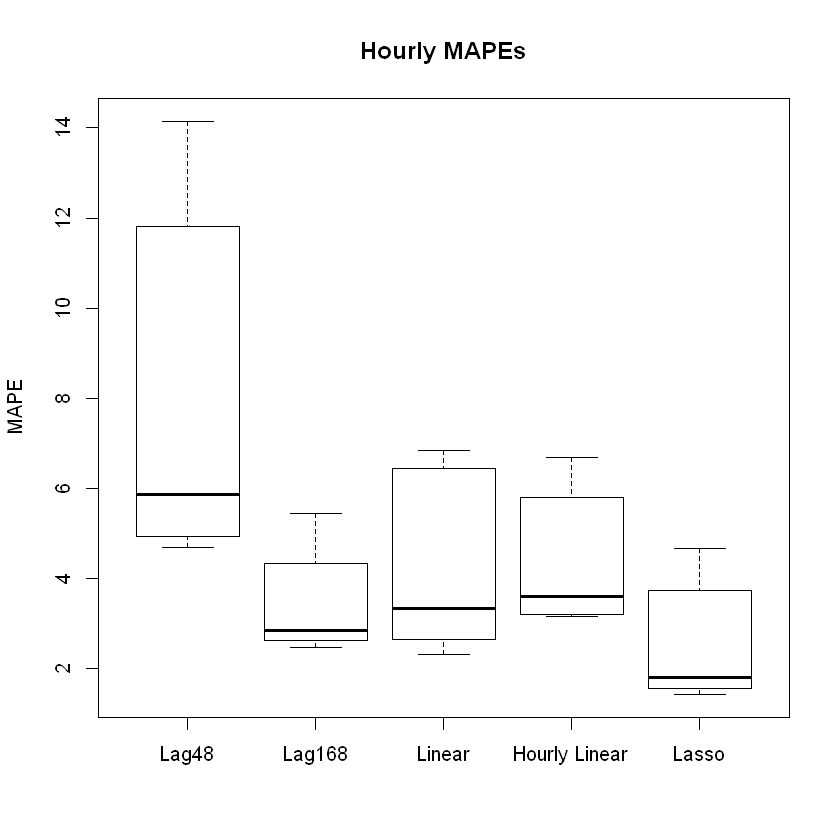

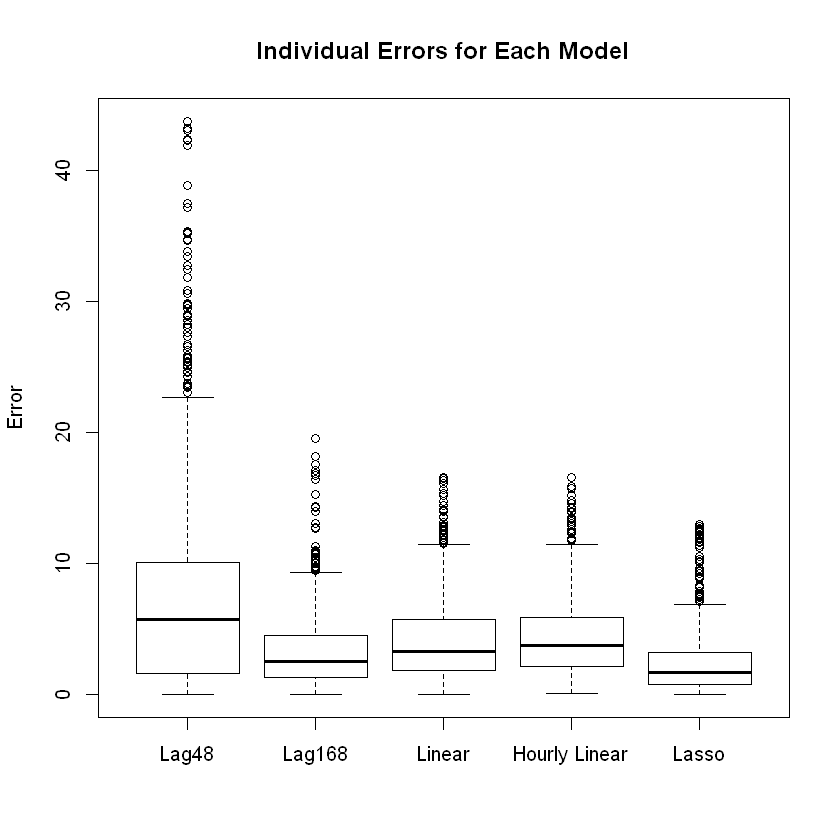

In [33]:
boxplot(MAPES_hourly, main= "Hourly MAPEs", ylab = "MAPE")
boxplot(OVR_Error, main= "Individual Errors for Each Model", ylab = "Error")

###### Comments on Task6
I did not quite understand if I should plot the errors or MAPE values. In order to plot the MAPE value I converted all models to hourly MAPEs to obtain uniformity. Observing each prediction's error is also nice so I plotted the second figure too. We observe lots of outliers in each model but all in all each model has MAPE value smaller than 10. Overall, Lasso prediction gives the lowest MAPE value which is a more complicated model than the others and it is expected to obtain better results in the Lasso Model. Our worse model is Lag48 data which only predicts the two days ago same hour consumption data as prediction and it is not a good vay (especially due to weekend/weekday difference). 